# Topical Expert Model

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import operator
import os
print(os.getcwd())
print(os.listdir('/Users/Brandon/Yelp Dataset/dataset'))
import json
import glob
from datetime import datetime
from pandas import HDFStore,DataFrame
import operator
import pylab as pl
import json

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import matplotlib

/Users/Brandon/Yelp Dataset/Yelp-FA17/local-elites/workspace
['.DS_Store', 'business.json', 'checkin.json', 'photos.json', 'review.json', 'review5000.json', 'tip.json', 'user.json', 'user5000.json']


In [2]:
#Copied from Kenta
def load_json_to_df(datapass):
    '''
    Load the json file and parse the file to pandas dataframe format
    
    Input:
        datapass(str) : directory to the json file
    Output:
        df(dataframe) : pandas dataframe object
    '''
    
    data = [] 
    with open(datapass) as data_file: 
        for f in data_file:
            data.append(json.loads(f))
    df = pd.DataFrame(data)
    return df

LOAD THE DATA

In [3]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/review.json"
review = load_json_to_df(import_file)
review = review.drop('text', 1)

CPU times: user 1min 5s, sys: 17.3 s, total: 1min 22s
Wall time: 1min 26s


In [4]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/business.json"
business = load_json_to_df(import_file)

CPU times: user 4.86 s, sys: 198 ms, total: 5.06 s
Wall time: 5.08 s


In [5]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/user.json"
user = load_json_to_df(import_file)

CPU times: user 47.8 s, sys: 3.68 s, total: 51.5 s
Wall time: 53.9 s


Sort by category

In [6]:
def categoryFind(df, cat):
    return [cat in i for i in df['categories']]

def category_counts(df):
    all_cats = []
    for i in df['categories']:
        for j in i:
            all_cats.append(j)
    categories = set(all_cats)
    category_counts = {}
    for cat in categories:
        category_counts[cat] = all_cats.count(cat)
    return len(categories), category_counts

def top_categories(counts, n):
    top_categories = sorted(counts.keys(), key=(lambda k: counts[k]),reverse=True)[:n]
    return top_categories

In [139]:
num_cats, cat_counts = category_counts(business)
top_cats = top_categories(cat_counts, 100)
display(top_cats)

['Restaurants',
 'Shopping',
 'Food',
 'Beauty & Spas',
 'Home Services',
 'Health & Medical',
 'Nightlife',
 'Bars',
 'Automotive',
 'Local Services',
 'Event Planning & Services',
 'Active Life',
 'Fashion',
 'Sandwiches',
 'Fast Food',
 'American (Traditional)',
 'Pizza',
 'Coffee & Tea',
 'Hair Salons',
 'Hotels & Travel',
 'Arts & Entertainment',
 'Home & Garden',
 'Auto Repair',
 'Italian',
 'Burgers',
 'Doctors',
 'Breakfast & Brunch',
 'Mexican',
 'Nail Salons',
 'Professional Services',
 'American (New)',
 'Chinese',
 'Real Estate',
 'Specialty Food',
 'Fitness & Instruction',
 'Pets',
 'Grocery',
 'Bakeries',
 'Cafes',
 'Hair Removal',
 'Dentists',
 'Hotels',
 'Desserts',
 'Skin Care',
 "Women's Clothing",
 'Education',
 'Japanese',
 'Ice Cream & Frozen Yogurt',
 'Pet Services',
 'Day Spas',
 'Massage',
 'General Dentistry',
 'Financial Services',
 'Pubs',
 'Chicken Wings',
 'Seafood',
 'Contractors',
 'Salad',
 'Gyms',
 'Sushi Bars',
 'Sports Bars',
 'Apartments',
 'Caterers

In [8]:
%%time
businessReviews = pd.merge(review, business,on='business_id',right_index=True,sort=False)[['business_id', 'cool', 'funny', 'review_id', 'stars_x', 'useful', 'user_id', 'categories', 'review_count', 'stars_y']]
bus_rev_users = pd.merge(businessReviews, user,on='user_id',right_index=True,sort=False)[['business_id', 'cool_x', 'funny_x', 'review_id', 'stars_x', 'useful_x', 'user_id', 'categories', 'stars_y', 'average_stars', 'cool_y', 'elite', 'fans', 'friends', 'name', 'review_count_y', 'yelping_since']]

CPU times: user 42 s, sys: 7.99 s, total: 50 s
Wall time: 53.2 s


In [9]:
%%time
businessReviews.info(memory_usage='deep')
#out = businessReviews.to_json(orient='records', lines=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4736897 entries, 0 to 4736896
Data columns (total 10 columns):
business_id     object
cool            int64
funny           int64
review_id       object
stars_x         int64
useful          int64
user_id         object
categories      object
review_count    int64
stars_y         float64
dtypes: float64(1), int64(5), object(4)
memory usage: 1.7 GB
CPU times: user 2.23 s, sys: 32.7 ms, total: 2.26 s
Wall time: 2.27 s


In [10]:
%%time
bus_rev_users.info(memory_usage='deep')
#with open(out, 'w') as f:
#    f.write(out)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4736897 entries, 0 to 4736896
Data columns (total 17 columns):
business_id       object
cool_x            int64
funny_x           int64
review_id         object
stars_x           int64
useful_x          int64
user_id           object
categories        object
stars_y           float64
average_stars     float64
cool_y            int64
elite             object
fans              int64
friends           object
name              object
review_count_y    int64
yelping_since     object
dtypes: float64(2), int64(7), object(8)
memory usage: 7.1 GB
CPU times: user 9.3 s, sys: 734 ms, total: 10 s
Wall time: 10.3 s


In [11]:
#with open('businessUsers.json', 'w') as f:
#    f.write(bus_rev_users.to_json(orient='records', lines=True))
for dtype in ['float','int','object']:
    selected_dtype = bus_rev_users.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 36.14 MB
Average memory usage for int columns: 36.14 MB
Average memory usage for object columns: 772.60 MB


In [12]:
display(len(businessReviews))
display(len(bus_rev_users))
display(list(businessReviews))
display(list(bus_rev_users))

4736897

4736897

['business_id',
 'cool',
 'funny',
 'review_id',
 'stars_x',
 'useful',
 'user_id',
 'categories',
 'review_count',
 'stars_y']

['business_id',
 'cool_x',
 'funny_x',
 'review_id',
 'stars_x',
 'useful_x',
 'user_id',
 'categories',
 'stars_y',
 'average_stars',
 'cool_y',
 'elite',
 'fans',
 'friends',
 'name',
 'review_count_y',
 'yelping_since']

## Feature Extraction From Yelp Data

In [13]:
def category_choose(df, categories):
    cats = np.array([True] * len(df['categories']))
    for cat in categories:
        cats= cats & np.array(categoryFind(df,cat))
    return df[cats]

def numCategoryReviews(businessReviews):
    return businessReviews[['business_id','user_id']].groupby('user_id',as_index=False).count()

def average_star_category_rating(businessReviews):
    return businessReviews[['user_id','stars_x']].groupby('user_id',as_index=False).mean()

def std_star_category_rating(businessReviews):
    busRev = businessReviews[['user_id','stars_x']].groupby('user_id',as_index=False).agg(np.var)
    busRev['stars_x'] = busRev['stars_x'].pow(1./2)
    return busRev

def funny_useful_cool(businessReviews):
    return businessReviews[['user_id','funny','useful','cool']].groupby('user_id',as_index=False).sum()

def months_yelping(businessReviews):
    user_dates = businessReviews[['user_id','yelping_since']].drop_duplicates()
    curr_date = datetime(2017,10,17)
    uyelp_dates = [datetime.strptime(i, "%Y-%m-%d") for i in user_dates['yelping_since']]
    months_yelping = [(curr_date.year - i.year) * 12 + curr_date.month - i.month for i in uyelp_dates]
    user_dates['yelping_since'] = months_yelping
    return user_dates

def get_elite_users(df):
    temp = []
    for i in df['elite'].index.values:
        if df['elite'][i]:
            temp.append(i)
    return temp, df.loc[temp]

## Define the first feature model to be analyzed
Features: Total Reviews by User, Number of Category Reviews, Average Rating in Category, Std Dev of Ratings in Category, Funny, Useful, and Cool Votes, Number of Months since joining Yelp.

In [14]:
def feature1(df, df1, categories):
    if( not categories == "All"):
        df = category_choose(df, categories)
        df1 = category_choose(df1, categories)
    tot_reviews = df1[['user_id','review_count_y']]
    tot_reviews.columns = ['user_id','Total Reviews by User']
    catRev = numCategoryReviews(df)
    catRev.columns = ['user_id','Num Category Reviews']
    averageCat = average_star_category_rating(df)
    averageCat.columns = ['user_id','Average Rating in Category']
    stdCat = std_star_category_rating(df)
    stdCat.columns = ['user_id','Std Dev of Ratings in Category']
    fuc = funny_useful_cool(df)
    monthsYelp = months_yelping(df1)
    monthsYelp.columns = ['user_id', 'Months Yelping']
    is_elite = df1[['user_id','elite']]
    features = tot_reviews.merge(catRev,on='user_id').merge(averageCat,on='user_id').merge(stdCat,on='user_id').merge(fuc,on='user_id').merge(monthsYelp,on='user_id').merge(is_elite,on='user_id')
    features = features.drop_duplicates('user_id')
    features.index = range(len(features))
    elite_ind, elite_users = get_elite_users(features)
    expertClassifier = [0]*len(features)
    for i in elite_ind:
        expertClassifier[i]=1
    features = pd.concat([features, pd.DataFrame(expertClassifier,columns=['is_expert'])],axis=1)
    return features.fillna(0)

# Feature 2 has all of feature 1 plus the number of friends for each user
def feature2(df, df1, categories, features1 = pd.DataFrame()):
    if features1.empty:
        features1= feature1(df,df1,categories)
    
    friends = pd.DataFrame([len(i) for i in df1['friends']], columns = ['Num_Friends'])
    users = pd.DataFrame(df1['user_id'].values,columns=['user_id'])
    num_friends = pd.concat([users, friends],axis=1)
    features1= features1.merge(num_friends,on='user_id').drop_duplicates('user_id')
    features1.index = range(len(features1))
    return features1
    

In [15]:
%%time
# Lets do places with categories Restaurant
categories = ['Restaurants', 'Pizza']
feature_set_1 = feature1(businessReviews, bus_rev_users, categories)

CPU times: user 17.8 s, sys: 3.06 s, total: 20.9 s
Wall time: 21.6 s


In [16]:
feature_set_1

,user_id,Total Reviews by User,Num Category Reviews,Average Rating in Category,Std Dev of Ratings in Category,funny,useful,cool,Months Yelping,elite,is_expert
0,c5yp5hxwC1N98MjbV2LyWQ,84,1,4.000000,0.000000,0,0,1,76,[],0
1,eqWEgMH-DCP74i82BEAZzw,359,1,4.000000,0.000000,1,2,2,113,"[2010, 2014, 2011, 2015, 2016, 2012, 2013]",1
2,IpLZ7RevQrFPJWYc9Gxymg,97,1,3.000000,0.000000,0,1,1,68,"[2013, 2014]",1
3,WZXp9-V2dqRRJqhGgRqueA,327,5,3.800000,0.836660,4,5,5,61,"[2016, 2015]",1
4,XylT12exfdLiI_3uDLVIpw,344,6,2.166667,1.602082,1,4,0,84,[],0
5,Ji9PeffxjwqPLO7pEfSpKQ,93,9,3.222222,1.301708,6,14,10,107,"[2010, 2009]",1
6,TLIWzAJPrET0zX4_vgvLhg,53,4,3.000000,0.816497,0,1,0,38,[],0
7,E56sVQT5-OWfSejJrma8_w,13,1,5.000000,0.000000,0,0,0,68,[],0
8,P8mVj7AZwJTFFH5FXbbmUg,5,2,4.500000,0.707107,0,0,0,33,[],0
9,O7G_c6wFXSygr82qs0GAcA,18,2,3.000000,2.828427,0,1,1,32,[],0


In [17]:
feature_set_2 = feature2(businessReviews, bus_rev_users, categories, feature_set_1)
feature_set_2

,user_id,Total Reviews by User,Num Category Reviews,Average Rating in Category,Std Dev of Ratings in Category,funny,useful,cool,Months Yelping,elite,is_expert,Num_Friends
0,c5yp5hxwC1N98MjbV2LyWQ,84,1,4.000000,0.000000,0,0,1,76,[],0,6
1,eqWEgMH-DCP74i82BEAZzw,359,1,4.000000,0.000000,1,2,2,113,"[2010, 2014, 2011, 2015, 2016, 2012, 2013]",1,257
2,IpLZ7RevQrFPJWYc9Gxymg,97,1,3.000000,0.000000,0,1,1,68,"[2013, 2014]",1,15
3,WZXp9-V2dqRRJqhGgRqueA,327,5,3.800000,0.836660,4,5,5,61,"[2016, 2015]",1,181
4,XylT12exfdLiI_3uDLVIpw,344,6,2.166667,1.602082,1,4,0,84,[],0,762
5,Ji9PeffxjwqPLO7pEfSpKQ,93,9,3.222222,1.301708,6,14,10,107,"[2010, 2009]",1,53
6,TLIWzAJPrET0zX4_vgvLhg,53,4,3.000000,0.816497,0,1,0,38,[],0,19
7,E56sVQT5-OWfSejJrma8_w,13,1,5.000000,0.000000,0,0,0,68,[],0,19
8,P8mVj7AZwJTFFH5FXbbmUg,5,2,4.500000,0.707107,0,0,0,33,[],0,0
9,O7G_c6wFXSygr82qs0GAcA,18,2,3.000000,2.828427,0,1,1,32,[],0,8


In [18]:
display(len(feature_set_1))
display(feature_set_1.head(5))

166811

,user_id,Total Reviews by User,Num Category Reviews,Average Rating in Category,Std Dev of Ratings in Category,funny,useful,cool,Months Yelping,elite,is_expert
0,c5yp5hxwC1N98MjbV2LyWQ,84,1,4.000000,0.000000,0,0,1,76,[],0
1,eqWEgMH-DCP74i82BEAZzw,359,1,4.000000,0.000000,1,2,2,113,"[2010, 2014, 2011, 2015, 2016, 2012, 2013]",1
2,IpLZ7RevQrFPJWYc9Gxymg,97,1,3.000000,0.000000,0,1,1,68,"[2013, 2014]",1
3,WZXp9-V2dqRRJqhGgRqueA,327,5,3.800000,0.836660,4,5,5,61,"[2016, 2015]",1
4,XylT12exfdLiI_3uDLVIpw,344,6,2.166667,1.602082,1,4,0,84,[],0


 #### Drop unnessary columns from the features table (call it X).

In [21]:
X = feature_set_1.drop('user_id',axis=1).drop('elite',axis=1)
X2 = feature_set_2.drop('user_id',axis=1).drop('elite',axis=1)

# Unsupervised Learning
## Kmeans Cluster

In [26]:
'''Runs the model specified by the clf (classifier), and features.
Features is assumed to have an 'is_expert' column which gives comparisons to unsupervised learning'''
from sklearn.cluster import KMeans
def run_unsup_model(clf, features):
    train = features.drop('is_expert',axis=1)
    clf.fit(train)
    rf_pred = clf.predict(train)
    model_perf= {'Model_Score' : clf.score(train),
                'Predictions' : rf_pred,
                'Total_Tested' : len(rf_pred),
                'Num_Experts_Predicted' : sum(rf_pred),
                'Num_Non_Experts' : sum(1-rf_pred),
                'Cluster_Centers' : clf.cluster_centers_,
                'Cluster_Points' : clf.transform(train)} 
    return model_perf

def graph_clusters(model):
    x = model['Cluster_Points'][:,0]
    y = model['Cluster_Points'][:,1]
    labels = model['Predictions']
    plt.scatter(x, y, c=[matplotlib.cm.spectral(float(i) /10) for i in labels]);   
    plt.show()

def add_pred_column(model, features):
    return features.assign(preds=pd.Series(model['Predictions']).values)

def unsup_statistics(model, features):
    features = add_pred_column(model, features)
    return {'Num_Experts' : sum(features.is_expert),
            'Num_Experts_Predicted' : sum(features.preds),
            'Intersection' : sum(features.is_expert & features.preds)}

def kmeans_model(n_clusters, X, feature_set):
    clf_KMeans = KMeans(n_clusters=n_clusters)
    model_test = run_unsup_model(clf_KMeans, X)
    display(graph_clusters(model_test))
    display(unsup_statistics(model_test, X))
    predictions = add_pred_column(model_test, feature_set)
    return predictions

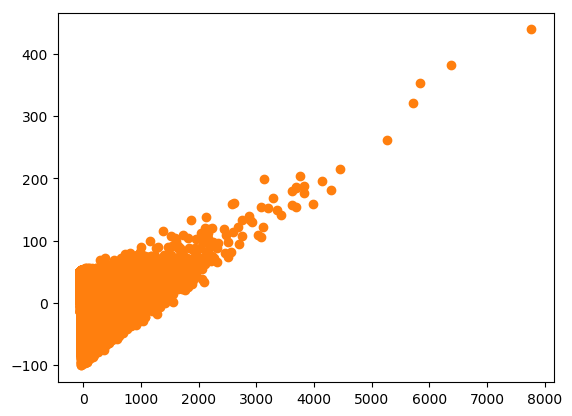

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)
pca_x = pca_2d[:,0]
pca_y = pca_2d[:,1]
pl.scatter(pca_x, pca_y)
plt.show()


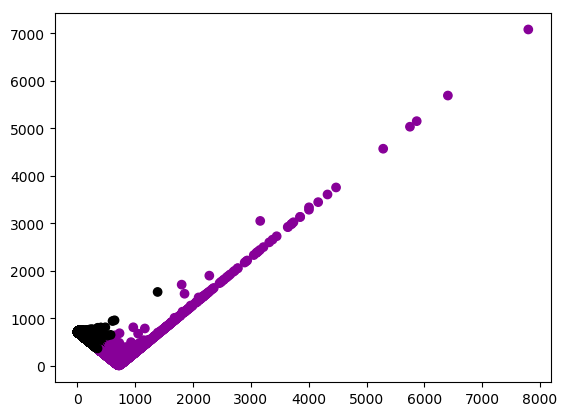

None

{'Intersection': 3295, 'Num_Experts': 17405, 'Num_Experts_Predicted': 3643}

CPU times: user 17.7 s, sys: 446 ms, total: 18.2 s
Wall time: 18.9 s


In [28]:
%%time
cat_feature_1 = kmeans_model(n_clusters = 2, X=X, feature_set = feature_set_1)

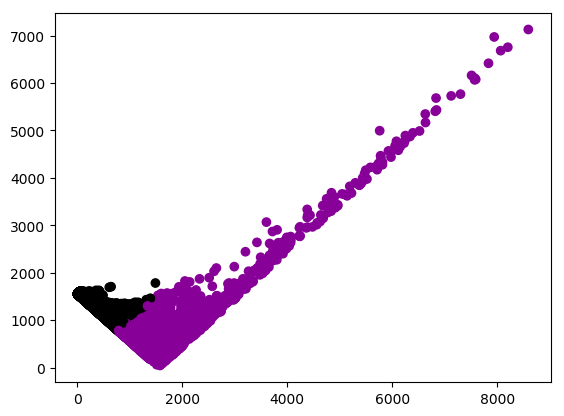

None

{'Intersection': 1458, 'Num_Experts': 17405, 'Num_Experts_Predicted': 1625}

CPU times: user 18.6 s, sys: 471 ms, total: 19 s
Wall time: 19.9 s


In [29]:
%%time
cat_feature_2 = kmeans_model(n_clusters = 2, X=X2, feature_set = feature_set_2)

In [30]:
my = X2['Months Yelping']>12
trbu = X2['Total Reviews by User']>10
ncr = X2['Num Category Reviews']>5
fuc = X2['funny'] + X2['useful'] + X2['cool'] > 15
nf = X2['Num_Friends']>10
list(X2)
sum(my & trbu & ncr & fuc & nf)


2088

## Evaluation Model

In [189]:
from sklearn.metrics import mean_squared_error
def evaluate_category(businessReviews, categories, category_features):
    bus_revs = category_choose(businessReviews, categories)[['business_id', 'review_id', 'user_id', 'stars_x', 'stars_y',]]
    
    cat_feat = category_features[['user_id', 'preds']]
    
    bus_revs_preds = pd.merge(bus_revs, cat_feat, on='user_id',right_index=True,sort=False).sort_values('business_id')
    bus_revs_preds.index = range(len(bus_revs_preds['business_id']))
    
    topic_evaluate = pd.DataFrame(columns=[['business_id', 'expert_stars','num_experts', 'avg_exp_stars', 'user_stars','num_users', 'avg_user_stars']])
    topic_evaluate['business_id']= bus_revs_preds.drop_duplicates('business_id')['business_id']
    topic_evaluate.index = range(len(topic_evaluate['business_id']))
    
    for i in range(0, len(topic_evaluate)):
        temp_bid = topic_evaluate['business_id'][i]
        temp_bus = bus_revs_preds[bus_revs_preds.business_id.isin([temp_bid])]
        temp_experts = temp_bus[temp_bus.preds==1]
        temp_users = temp_bus[temp_bus.preds==0]
        topic_evaluate['expert_stars'][i] = temp_experts['stars_x'].sum()
        topic_evaluate['num_experts'][i] = len(temp_experts)
        topic_evaluate['avg_exp_stars'][i] = temp_experts['stars_x'].mean()
        topic_evaluate['user_stars'][i] = temp_users['stars_x'].sum()
        topic_evaluate['num_users'][i] = len(temp_users)
        topic_evaluate['avg_user_stars'][i] = temp_users['stars_x'].mean()
    topic_evaluate.head(10)
    
    cat_evals = topic_evaluate.dropna()
    return cat_evals

def evaluate_category_stats(cat_evals, plot):
    diffs = (cat_evals['avg_exp_stars'] - cat_evals['avg_user_stars'])
    if(plot):
        diffs.plot(kind='hist')
        plt.show()
        
        tmp1 = []
        for i in range(1,30):
            tmp1.append(len(cat_evals[cat_evals.num_experts==i]))
        pd.DataFrame(tmp1,columns=['Frequency']).plot(y='Frequency')
        plt.show()
    
    num_bus = len(topic_evaluate)
    num_bus_with_experts = len(diffs)
    mean_diff = abs(diffs).mean()
    if not cat_evals['avg_exp_stars'].empty:
        MSE = mean_squared_error(cat_evals['avg_user_stars'], cat_evals['avg_exp_stars'])
    else:
        MSE = np.nan
    cat_dict = {'Categories': categories, 'num_bus' : num_bus, 'bus_with_experts' : num_bus_with_experts,
                'mean_abs_diff' : mean_diff, 'MSE' : MSE}
    return cat_dict
    
def evaluate_category_single(businessReviews, categories, category_features, plot):
    return evaluate_category_stats(evaluate_category(businessReviews, categories, category_features), plot)

def evaluate_categories(businessReviews, bus_rev_users, categories):
    evaluation = pd.DataFrame()
    for cat in categories:
        feature_set = feature1(businessReviews, bus_rev_users, cat)
        X = feature_set_1.drop('user_id',axis=1).drop('elite',axis=1)
        cat_features = kmeans_model(n_clusters = 2, X=X, feature_set = feature_set_1)
        this_eval = evaluate_category_single(businessReviews, cat, cat_features, False)
        evaluation.append(pd.DataFrame(pd.Series(this_eval)).transpose())
    return evaluation

def evaluate_categories_kmeans():

In [200]:
cat_dict = evaluate_category_single(businessReviews, categories, cat_feature_1, False)

In [201]:
cat_dict

{'Categories': ['Restaurants', 'Pizza'],
 'MSE': 0.7929394324803668,
 'bus_with_experts': 3179,
 'mean_abs_diff': 0.66358052462060957,
 'num_bus': 5652}

In [126]:
cat_evals.head(10)

,business_id,expert_stars,num_experts,avg_exp_stars,user_stars,num_users,avg_user_stars
2,--U98MNlDym2cLn36BBPgQ,3,1,3,8,3,2.66667
5,-0KMvRFwDWdVBeTpT11iHw,4,1,4,4,2,2
6,-0Sgh0QlUKVsWosCWJzGqQ,6,2,3,71,40,1.775
9,-5NXoZeGBdx3Bdk70tuyCw,7,2,3.5,200,52,3.84615
11,-6h3K1hj0d4DRcZNUtHDuw,35,9,3.88889,1505,412,3.65291
13,-7PX_FOoCwktlunImRyZdg,13,3,4.33333,382,90,4.24444
15,-8ILwSisSrTzcyy_Z0o9oA,10,3,3.33333,139,42,3.30952
16,-9y6MruLgFTNrl11SQRPFA,9,2,4.5,25,6,4.16667
18,-CfFjcCcGGDM9MVH_d42RQ,4,1,4,828,219,3.78082
20,-DU8jf5nA1_yaOqsKsLqmw,4,1,4,32,8,4


In [197]:
EVALUATION = evaluate_categories(businessReviews, bus_rev_users, top_cats[10:12])

In [198]:
EVALUATION

""


In [202]:
top_cats[0]

'Restaurants'